# Time Series Analysis of Team Statistics


In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import yaml
from IPython.display import Markdown, display
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import linregress

In [178]:
# load yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
    DATA_PATH = config.get("data_path")
    if DATA_PATH is None:
        print("ERROR: No data path provided")
    USE_DRIVE = bool(config.get("use_drive", False))

In [179]:
# load from drive if requested
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [4]:
# load team data
team_statistics_df = pd.read_csv(os.path.join(DATA_PATH, "team_statistics.csv"))
team_statistics_df.info()
team_statistics_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91649 entries, 0 to 91648
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   91649 non-null  int64  
 1   gameDate                 91649 non-null  object 
 2   teamCity                 91649 non-null  object 
 3   teamName                 91649 non-null  object 
 4   teamId                   91649 non-null  int64  
 5   opponentTeamCity         91649 non-null  object 
 6   opponentTeamName         91649 non-null  object 
 7   opponentTeamId           91649 non-null  int64  
 8   home                     91649 non-null  int64  
 9   win                      91649 non-null  int64  
 10  teamScore                91649 non-null  int64  
 11  opponentScore            91649 non-null  int64  
 12  assists                  91645 non-null  float64
 13  blocks                   91632 non-null  float64
 14  steals                

gameId             gameDate   teamCity teamName      teamId  \
0  22401058  2025-03-26 22:00:00     Boston  Celtics  1610612738   
1  22401058  2025-03-26 22:00:00    Phoenix     Suns  1610612756   
2  22401057  2025-03-26 21:00:00     Denver  Nuggets  1610612743   
3  22401057  2025-03-26 21:00:00  Milwaukee    Bucks  1610612749   
4  22401054  2025-03-26 19:30:00   Brooklyn     Nets  1610612751   

  opponentTeamCity opponentTeamName  opponentTeamId  home  win  ...  \
0          Phoenix             Suns      1610612756     0    1  ...   
1           Boston          Celtics      1610612738     1    0  ...   
2        Milwaukee            Bucks      1610612749     1    1  ...   
3           Denver          Nuggets      1610612743     0    0  ...   
4          Toronto          Raptors      1610612761     1    0  ...   

   biggestScoringRun  leadChanges  pointsFastBreak  pointsFromTurnovers  \
0               15.0          0.0              9.0                 16.0   
1               10.0          0.0              9.0                  7.0   
2                9.0          2.0             20.0                 18.0   
3                7.0          2.0              5.0                 17.0   
4                8.0          0.0             12.0                  7.0   

   pointsInThePaint  pointsSecondChance  timesTied  timeoutsRemaining  \
0              44.0                17.0        0.0                1.0   
1              36.0                16.0        0.0                1.0   
2              64.0                16.0        4.0                1.0   
3              56.0                13.0        4.0                0.0   
4              46.0                12.0        1.0                1.0   

   seasonWins  seasonLosses  
0        54.0          19.0  
1        35.0          38.0  
2        46.0          28.0  
3        40.0          32.0  
4        23.0          50.0  

[5 rows x 47 columns]

In [5]:
# time series where gameDate is the time column
team_statistics_df["gameDate"] = pd.to_datetime(team_statistics_df["gameDate"])

In [6]:
# drop columns not needed
cols_to_drop = ["gameId", "teamCity", "teamName", "opponentTeamCity", "opponentTeamName",
                "fieldGoalsAttempted", "fieldGoalsMade",
                "threePointersAttempted", "threePointersMade",
                "freeThrowsAttempted", "freeThrowsMade",
                "reboundsDefensive", "reboundsOffensive"
                ]
team_df = team_statistics_df
team_df.drop(columns=cols_to_drop, inplace=True)

In [7]:
team_df.head()

gameDate      teamId  opponentTeamId  home  win  teamScore  \
0 2025-03-26 22:00:00  1610612738      1610612756     0    1        132   
1 2025-03-26 22:00:00  1610612756      1610612738     1    0        102   
2 2025-03-26 21:00:00  1610612743      1610612749     1    1        127   
3 2025-03-26 21:00:00  1610612749      1610612743     0    0        117   
4 2025-03-26 19:30:00  1610612751      1610612761     1    0         86   

   opponentScore  assists  blocks  steals  ...  biggestScoringRun  \
0            102     33.0     7.0     8.0  ...               15.0   
1            132     22.0     3.0     7.0  ...               10.0   
2            117     36.0     4.0     6.0  ...                9.0   
3            127     30.0     6.0     4.0  ...                7.0   
4            116     16.0     9.0     6.0  ...                8.0   

   leadChanges  pointsFastBreak  pointsFromTurnovers  pointsInThePaint  \
0          0.0              9.0                 16.0              44.0   
1          0.0              9.0                  7.0              36.0   
2          2.0             20.0                 18.0              64.0   
3          2.0              5.0                 17.0              56.0   
4          0.0             12.0                  7.0              46.0   

   pointsSecondChance  timesTied  timeoutsRemaining  seasonWins  seasonLosses  
0                17.0        0.0                1.0        54.0          19.0  
1                16.0        0.0                1.0        35.0          38.0  
2                16.0        4.0                1.0        46.0          28.0  
3                13.0        4.0                0.0        40.0          32.0  
4                12.0        1.0                1.0        23.0          50.0  

[5 rows x 34 columns]

In [8]:
team_df.describe()

gameDate        teamId  opponentTeamId  \
count                          91649  9.164900e+04    9.164900e+04   
mean   2006-01-14 20:38:55.725649024  1.610613e+09    1.610613e+09   
min              1981-11-03 20:00:00  1.610613e+09    1.610613e+09   
25%              1996-03-17 20:00:00  1.610613e+09    1.610613e+09   
50%              2006-03-10 19:00:00  1.610613e+09    1.610613e+09   
75%              2015-12-07 19:30:00  1.610613e+09    1.610613e+09   
max              2025-03-26 22:00:00  1.610613e+09    1.610613e+09   
std                              NaN  8.560837e+00    8.562666e+00   

               home           win     teamScore  opponentScore       assists  \
count  91649.000000  91649.000000  91649.000000   91649.000000  91645.000000   
mean       0.499471      0.498347    102.799725     102.828869     23.115991   
min        0.000000      0.000000     49.000000      49.000000      4.000000   
25%        0.000000      0.000000     93.000000      93.000000     19.000000   
50%        0.000000      0.000000    102.000000     102.000000     23.000000   
75%        1.000000      1.000000    112.000000     112.000000     27.000000   
max        1.000000      1.000000    176.000000     176.000000     52.000000   
std        0.500002      0.500000     13.700946      13.710616      5.524858   

             blocks        steals  ...  biggestScoringRun  leadChanges  \
count  91632.000000  91341.000000  ...        2150.000000  2150.000000   
mean       5.003121      7.905628  ...          10.153488     6.716279   
min        0.000000      0.000000  ...           5.000000     0.000000   
25%        3.000000      6.000000  ...           8.000000     2.000000   
50%        5.000000      8.000000  ...          10.000000     5.000000   
75%        7.000000     10.000000  ...          12.000000    10.000000   
max       23.000000     27.000000  ...          24.000000    42.000000   
std        2.654206      3.046092  ...           2.674992     6.056848   

       pointsFastBreak  pointsFromTurnovers  pointsInThePaint  \
count      2150.000000          2150.000000       2150.000000   
mean         15.486512            17.525116         48.939535   
min           0.000000             0.000000         18.000000   
25%          11.000000            13.000000         42.000000   
50%          15.000000            17.000000         48.000000   
75%          20.000000            22.000000         56.000000   
max          46.000000            45.000000         88.000000   
std           6.614039             6.710324         10.397187   

       pointsSecondChance    timesTied  timeoutsRemaining   seasonWins  \
count         2150.000000  2150.000000        2150.000000  2150.000000   
mean            14.128372     4.840930           0.452093    18.233023   
min              0.000000     0.000000           0.000000     0.000000   
25%             10.000000     2.000000           0.000000     8.000000   
50%             14.000000     4.000000           0.000000    16.000000   
75%             18.000000     7.000000           1.000000    27.000000   
max             36.000000    22.000000           1.000000    60.000000   
std              5.706591     4.124381           0.497815    12.536114   

       seasonLosses  
count   2150.000000  
mean      18.280465  
min        0.000000  
25%        8.000000  
50%       17.000000  
75%       27.000000  
max       57.000000  
std       12.495395  

[8 rows x 34 columns]

## EDA

In [9]:
team_df.columns

Index(['gameDate', 'teamId', 'opponentTeamId', 'home', 'win', 'teamScore',
       'opponentScore', 'assists', 'blocks', 'steals', 'fieldGoalsPercentage',
       'threePointersPercentage', 'freeThrowsPercentage', 'reboundsTotal',
       'foulsPersonal', 'turnovers', 'plusMinusPoints', 'numMinutes',
       'q1Points', 'q2Points', 'q3Points', 'q4Points', 'benchPoints',
       'biggestLead', 'biggestScoringRun', 'leadChanges', 'pointsFastBreak',
       'pointsFromTurnovers', 'pointsInThePaint', 'pointsSecondChance',
       'timesTied', 'timeoutsRemaining', 'seasonWins', 'seasonLosses'],
      dtype='object')

In [44]:
# plot all cols, except teamId and opponentTeamId in a line plot wehre gameDate is on the x axis
# plot all of them in one big plot with subplots
def plot_all_cols(df, cols, plot_width=12):
    # need at least two cols
    if len(cols) < 2:
        raise ValueError("Need at least two cols")
    dont_plot = ["teamId", "opponentTeamId"]
    df = df.drop(columns=dont_plot, errors="ignore")
    fig, axs = plt.subplots(nrows=len(cols), ncols=1, figsize=(plot_width,4*len(cols)))
    for i, col in enumerate(cols):
        if col not in dont_plot:
            axs[i].plot(df["gameDate"], df[col])
            axs[i].set_title(col)
            axs[i].set_xlabel("gameDate")
            axs[i].set_ylabel(col)
            # more space between the plots
            plt.subplots_adjust(hspace=0.5)
    plt.show()

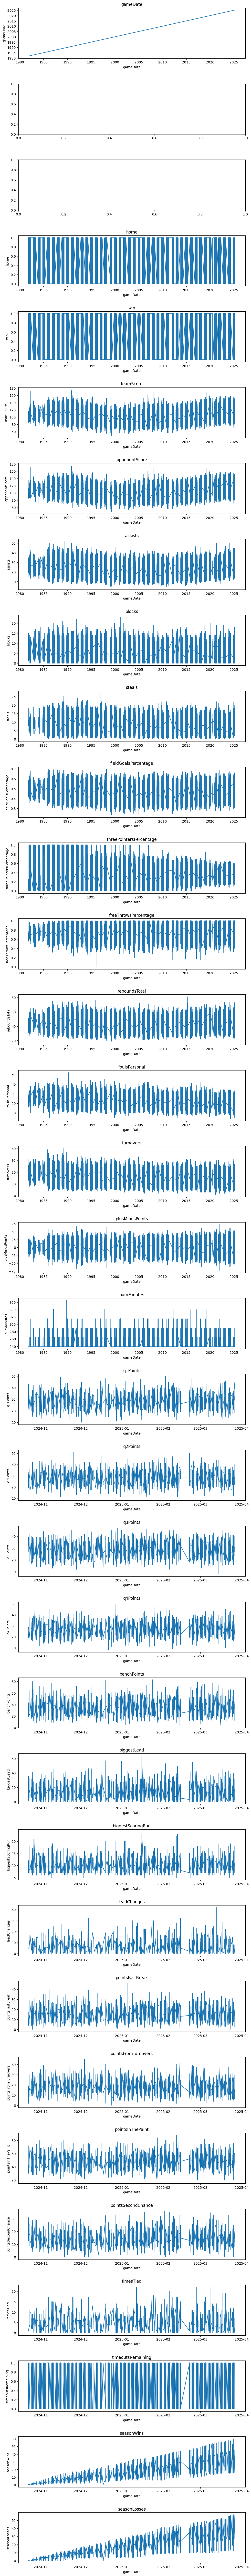

In [42]:
plot_all_cols(team_df, team_df.columns)

Okay this is now the plot for all teams, this is not very helpful.

However, we can see that some statistic was only started to be collected later. Thus, let's split agian the `df` and select only those columns which have the record since 1981

In [ ]:
cols_to_keep = []
# select only cols which have a min value in the year 1981
for col in team_df.columns:
    if col == "gameDate":
        continue
    # if we would select only that col and gameDate, would the min of gameDate be 1981?
    col_df = team_df[["gameDate", col]]
    # drop all nan and 0s
    col_df = col_df.dropna()
    col_df = col_df[col_df[col] != 0]
    # get min
    min_year = col_df["gameDate"].min().year
    if min_year == 1981:
        cols_to_keep.append(col)

team_df = team_df[["gameDate"] + cols_to_keep]
team_df.describe()

gameDate        teamId  opponentTeamId  \
count                          91649  9.164900e+04    9.164900e+04   
mean   2006-01-14 20:38:55.725649024  1.610613e+09    1.610613e+09   
min              1981-11-03 20:00:00  1.610613e+09    1.610613e+09   
25%              1996-03-17 20:00:00  1.610613e+09    1.610613e+09   
50%              2006-03-10 19:00:00  1.610613e+09    1.610613e+09   
75%              2015-12-07 19:30:00  1.610613e+09    1.610613e+09   
max              2025-03-26 22:00:00  1.610613e+09    1.610613e+09   
std                              NaN  8.560837e+00    8.562666e+00   

               home           win     teamScore  opponentScore       assists  \
count  91649.000000  91649.000000  91649.000000   91649.000000  91645.000000   
mean       0.499471      0.498347    102.799725     102.828869     23.115991   
min        0.000000      0.000000     49.000000      49.000000      4.000000   
25%        0.000000      0.000000     93.000000      93.000000     19.000000   
50%        0.000000      0.000000    102.000000     102.000000     23.000000   
75%        1.000000      1.000000    112.000000     112.000000     27.000000   
max        1.000000      1.000000    176.000000     176.000000     52.000000   
std        0.500002      0.500000     13.700946      13.710616      5.524858   

             blocks        steals  fieldGoalsPercentage  \
count  91632.000000  91341.000000          91649.000000   
mean       5.003121      7.905628              0.460987   
min        0.000000      0.000000              0.234000   
25%        3.000000      6.000000              0.422000   
50%        5.000000      8.000000              0.460000   
75%        7.000000     10.000000              0.500000   
max       23.000000     27.000000              0.697000   
std        2.654206      3.046092              0.057522   

       threePointersPercentage  freeThrowsPercentage  reboundsTotal  \
count             91649.000000           91649.00000   91649.000000   
mean                  0.343249               0.75815      42.767919   
min                   0.000000               0.00000      17.000000   
25%                   0.261000               0.69600      38.000000   
50%                   0.345000               0.76500      43.000000   
75%                   0.429000               0.82600      47.000000   
max                   1.000000               1.00000      81.000000   
std                   0.147039               0.10003       6.751799   

       foulsPersonal     turnovers  plusMinusPoints    numMinutes  
count   91649.000000  91595.000000     91015.000000  91649.000000  
mean       21.562505     14.847546         0.123782    241.713057  
min         4.000000      1.000000       -73.000000    240.000000  
25%        18.000000     12.000000        -9.000000    240.000000  
50%        21.000000     15.000000         1.000000    240.000000  
75%        25.000000     17.000000         9.000000    240.000000  
max        52.000000     40.000000        73.000000    365.000000  
std         4.754360      4.148831        13.745173      7.328626

## Let's select some teams

In [ ]:
def plot_time_series(dataframes, columns, fig_colsize=6):
    # Number of columns excluding 'gameDate'
    num_columns = len(columns) - 1

    fig, axes = plt.subplots(nrows=num_columns, ncols=len(dataframes), figsize=(fig_colsize*len(dataframes), num_columns * 3), sharex=True)

    # Iterate over each dataframe and each column
    for col_idx, column in enumerate(columns):
        if column == 'gameDate':
            continue

        for df_idx, df in enumerate(dataframes):
            ax = axes[col_idx-1, df_idx] if num_columns > 1 else axes[df_idx]
            ax.plot(df['gameDate'], df[column], label=f'DF {df_idx + 1}')
            ax.set_title(f'{column} (DF {df_idx + 1})')
            ax.set_xlabel('Game Date')
            ax.set_ylabel(column)
            ax.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
# select 3 teams randomly and plot the plots for those
teamsIds = team_df["teamId"].unique()
np.random.seed(42)
teamsIds_chosen = np.random.choice(teamsIds, 3, replace=False)

teamsIds_chosen

# create 3 data frames selected only by those teams
team_dfs_chosen = []
for teamId in teamsIds_chosen:
    team_dfs_chosen.append(team_df[team_df["teamId"] == teamId])

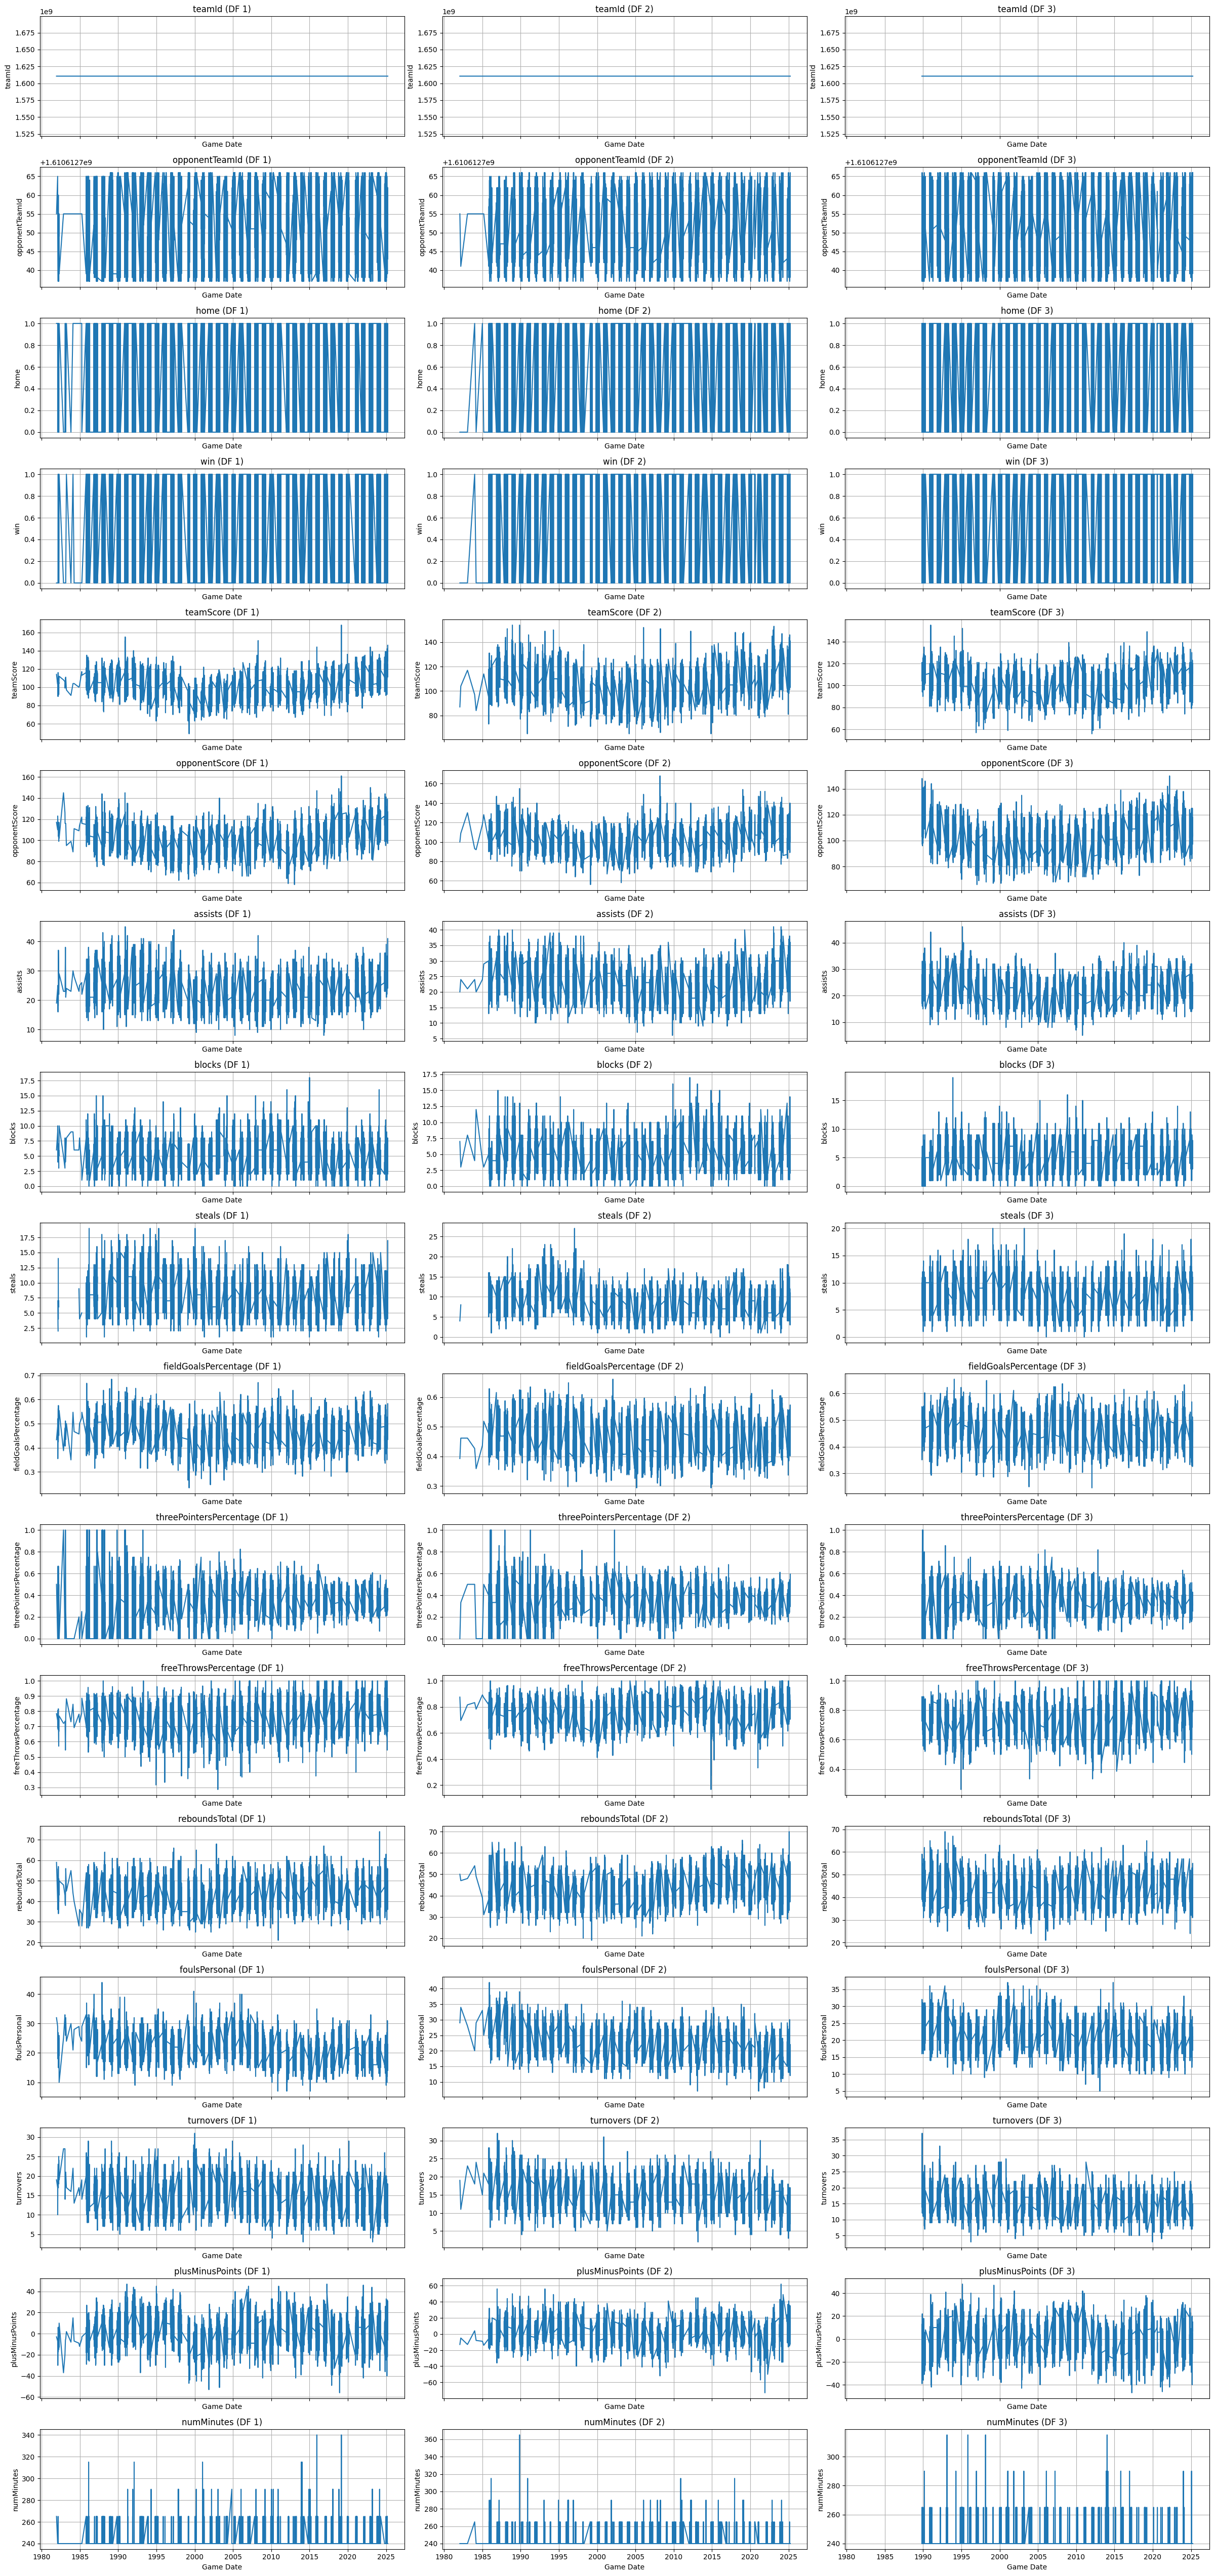

In [ ]:
# plot teams
plot_time_series(team_dfs_chosen, team_dfs_chosen[0].columns, fig_colsize=8)

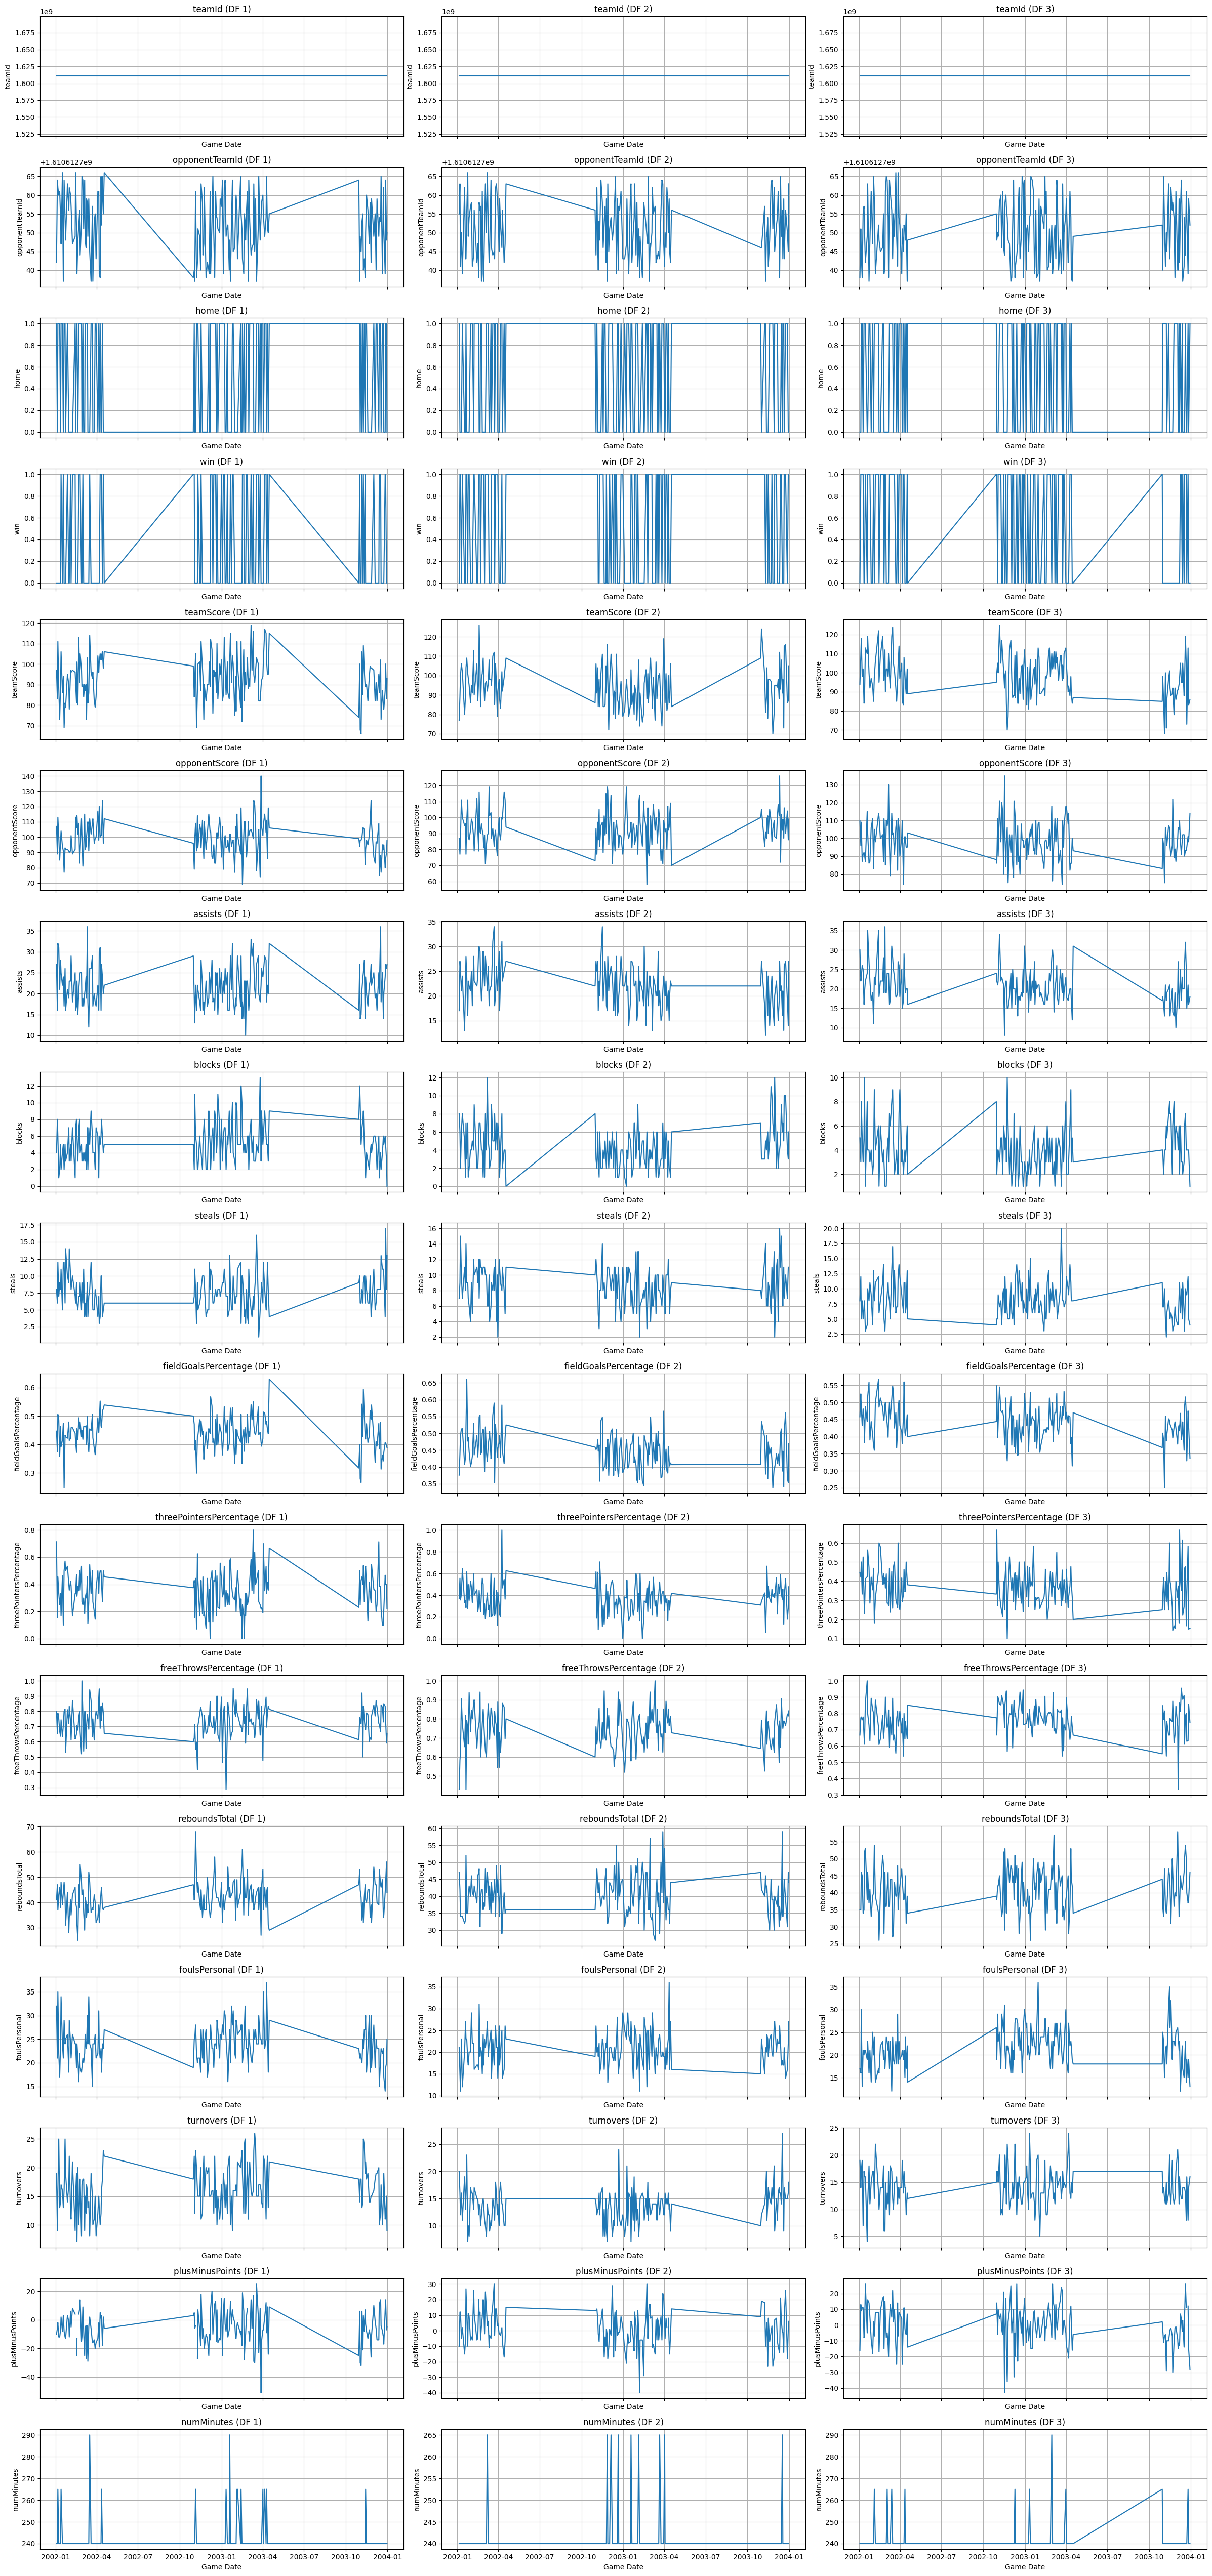

In [ ]:
# hard to tell something, lets select only one year

year = 2002

team_dfs_chosen_year = []
for t in team_dfs_chosen:
    # filter for rows that are in the year 'year' or year+1
    team_dfs_chosen_year.append(t[t["gameDate"].dt.year.isin([year, year+1])])

# plot again
plot_time_series(team_dfs_chosen_year, team_dfs_chosen_year[0].columns, fig_colsize=8)

`NumMinutes` probably not good.

# TS analysis of teamScore

## Seasonal decompose

In [11]:
team_score_df = team_df[["gameDate", "teamScore", "opponentScore"]]
team_score_df.set_index("gameDate", inplace=True)
team_score_df.sort_index(inplace=True, ascending=True)
team_score_df.head()
team_score_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91649 entries, 1981-11-03 20:00:00 to 2025-03-26 22:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   teamScore      91649 non-null  int64
 1   opponentScore  91649 non-null  int64
dtypes: int64(2)
memory usage: 2.1 MB


<ipython-input-11-cc3ca1f777c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_score_df.sort_index(inplace=True, ascending=True)


In [22]:
team_score_df.describe()

teamScore  opponentScore
count  91649.000000   91649.000000
mean     102.799725     102.828869
std       13.700946      13.710616
min       49.000000      49.000000
25%       93.000000      93.000000
50%      102.000000     102.000000
75%      112.000000     112.000000
max      176.000000     176.000000

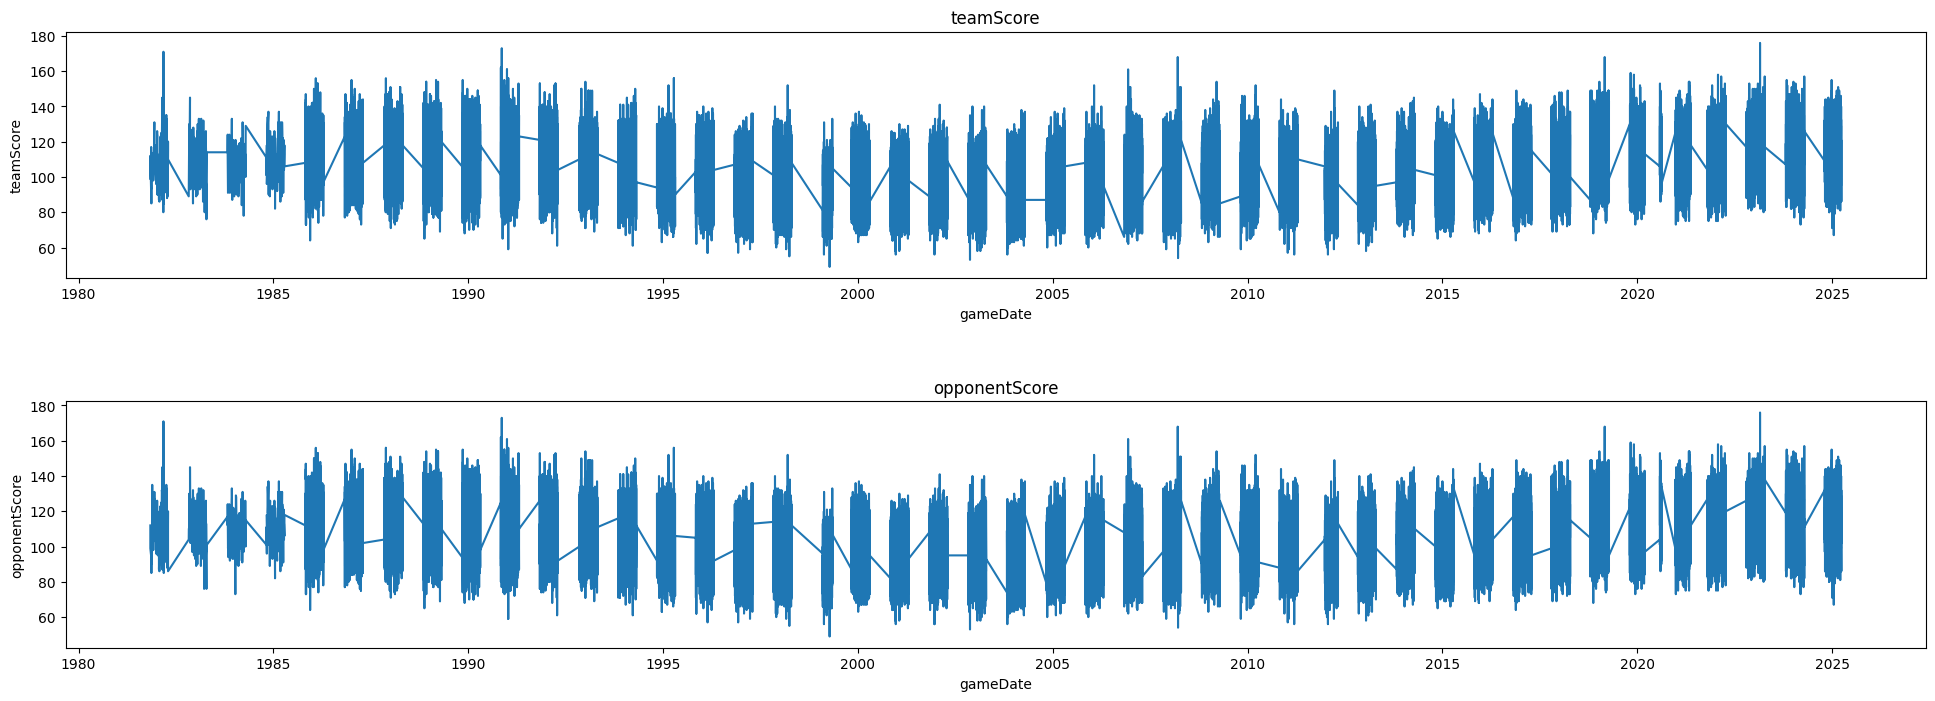

In [14]:
# plot again the teamScore
plot_all_cols(team_df, ["teamScore", "opponentScore"], plot_width=24)


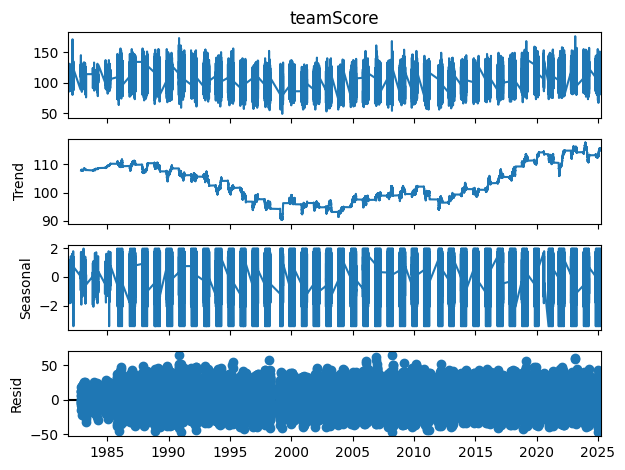

In [15]:
# seasonal decompose
decomposition = seasonal_decompose(team_score_df["teamScore"], model='additive', period=365)

# plot
decomposition.plot()
plt.show()

Seasonal decomposition analysis:

- The trend looks not really monotonically increasing, but also not constant... -> think more about what that means
- the season variance is fairly constant during the seasonal games (always between boundaries of $\pm 2$
- the error looks random and symetric around the 0 which is good

**analyze rule changes**: below after first arima section -> with new normalized data frame

## ARIMA

**find out if stationary or non-stationary**
- todo remove trend

First we need to find arima params $p,d,q$

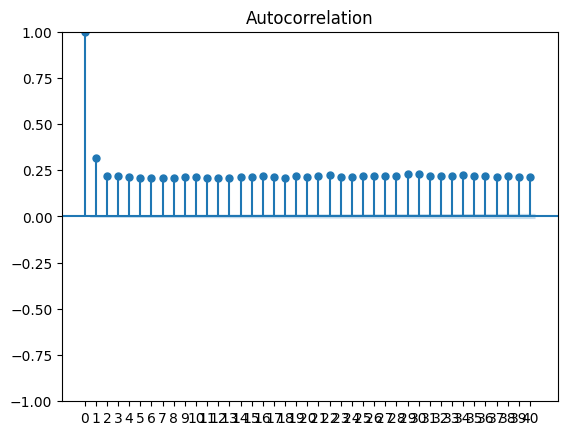

In [17]:
# identify sarima parameters
# acf plot
plot_acf(team_score_df["teamScore"], lags=40)
# ticks
plt.xticks(np.arange(0, 41, 1))
plt.show()

acf indicates almost 0 at $q=1$

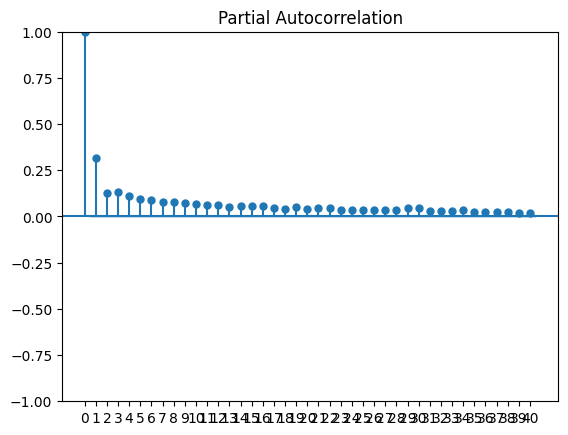

In [18]:
# pac plot
plot_pacf(team_score_df["teamScore"], lags=40)
# ticks
plt.xticks(np.arange(0, 41, 1))
plt.show()

pac indicates almost 0 at $p = 2$

In [19]:
q = 1
p = 2
d = 0

In [20]:
sarima_model = SARIMAX(team_score_df["teamScore"], order=(p, d, q))
sarima_model_fit = sarima_model.fit()

print(sarima_model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:              teamScore   No. Observations:                91649
Model:               SARIMAX(2, 0, 1)   Log Likelihood             -358195.073
Date:                Mon, 28 Apr 2025   AIC                         716398.146
Time:                        16:26:12   BIC                         716435.849
Sample:                             0   HQIC                        716409.633
                              - 91649                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1304      0.002    476.961      0.000       1.126       1.135
ar.L2         -0.1304      0.002    -55.008      0.000      -0.135      -0.126
ma.L1         -0.9952      0.000  -3106.688      0.0

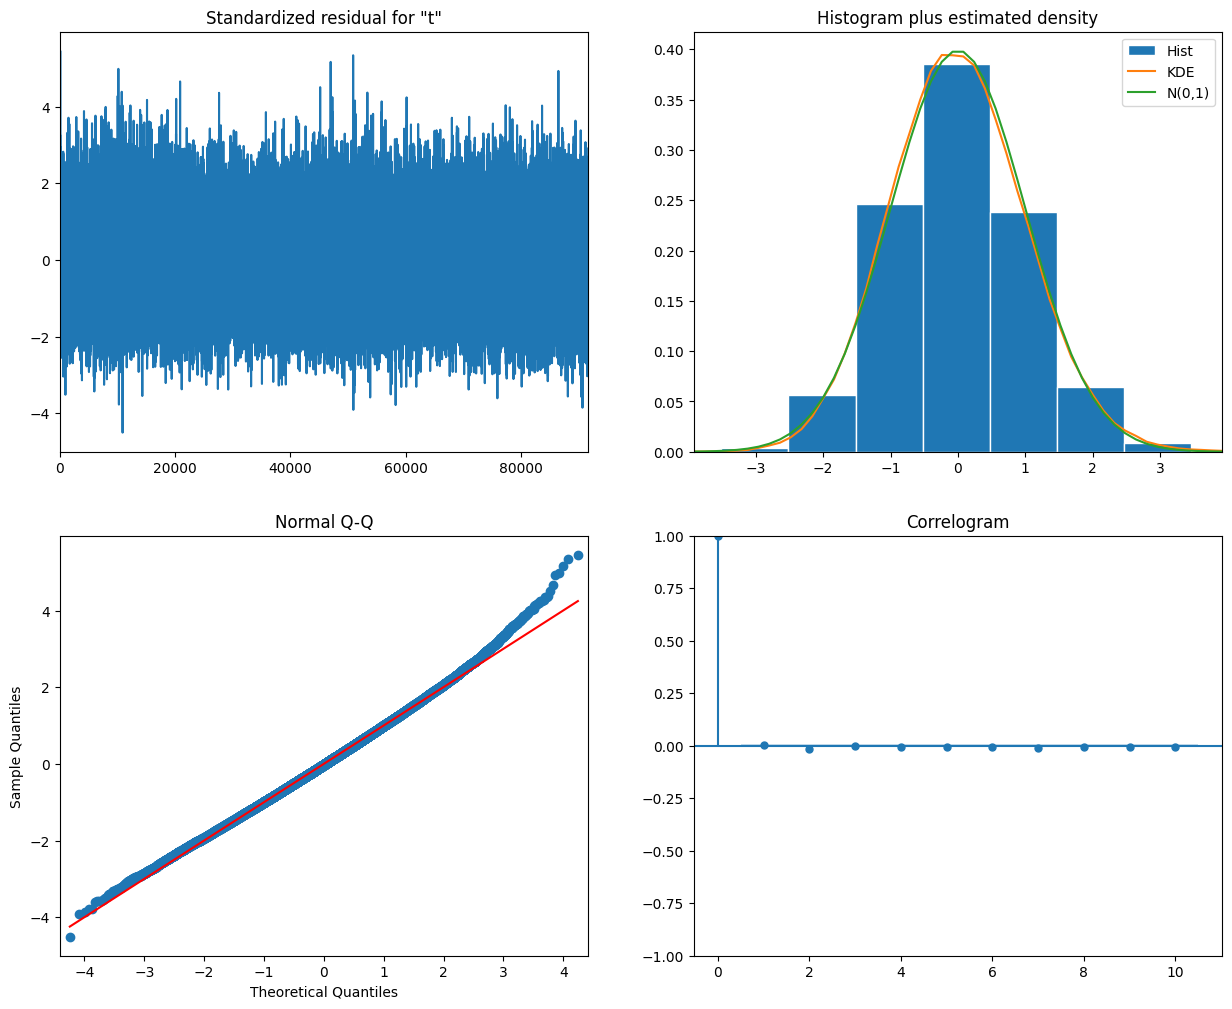

In [21]:
# plot residuals
sarima_model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

- The standardized residials look fairly random
- the histogram is normal distributed
- same for the qq plot
- the correlation has one spike for the x=0
  - does not change, even if we increase p or q

**todo: prediction**
- who wins -> todo how exactly?
- acf/pacf: how many games before are relevant to predict the next one -> window size for predictions


**todo: arima with multiple predictors**
- e.g. points, assists, etc. is relevant to predict total score (of game)
- then predict for team a and b the each the teamScore (based on the last n games) and then compare
- or predict the win (todo find out what is easier)

# With normalized data set

in the mean time we normalized the dataset of team statistics

In [273]:
team_stat_df = pd.read_csv(os.path.join(DATA_PATH, "team_statistics_important_features.csv"))
team_stat_df["gameDate"] = pd.to_datetime(team_statistics_df["gameDate"])
team_stat_df.sort_index(inplace=True, ascending=False)
team_stat_df.set_index("gameDate", inplace=True)
team_stat_df.head()

gameId       teamCity   teamName opponentTeamCity  \
gameDate                                                                   
1985-12-11 20:00:00  22300001        Indiana     Pacers        Cleveland   
1985-12-11 20:00:00  22300001      Cleveland  Cavaliers          Indiana   
1985-12-11 20:00:00  22300002       New York     Knicks        Milwaukee   
1985-12-11 20:00:00  22300002      Milwaukee      Bucks         New York   
1985-12-11 20:00:00  22300005  Oklahoma City    Thunder     Golden State   

                    opponentTeamName  home  win  teamScore  opponentScore  \
gameDate                                                                    
1985-12-11 20:00:00        Cavaliers     1    1        121            116   
1985-12-11 20:00:00           Pacers     0    0        116            121   
1985-12-11 20:00:00            Bucks     0    0        105            110   
1985-12-11 20:00:00           Knicks     1    1        110            105   
1985-12-11 20:00:00         Warriors     1    0        139            141   

                     threePointersPercentage  ...  blocksPerPossession  \
gameDate                                      ...                        
1985-12-11 20:00:00                    0.484  ...             0.046057   
1985-12-11 20:00:00                    0.286  ...             0.087379   
1985-12-11 20:00:00                    0.256  ...             0.009804   
1985-12-11 20:00:00                    0.513  ...             0.108567   
1985-12-11 20:00:00                    0.517  ...             0.009242   

                     stealsPerPossession  threePointersAttemptedPerPossession  \
gameDate                                                                        
1985-12-11 20:00:00             0.064480                             0.285556   
1985-12-11 20:00:00             0.097087                             0.271845   
1985-12-11 20:00:00             0.058824                             0.382353   
1985-12-11 20:00:00             0.059218                             0.384919   
1985-12-11 20:00:00             0.027726                             0.268022   

                     freeThrowsAttemptedPerPossession  \
gameDate                                                
1985-12-11 20:00:00                          0.221076   
1985-12-11 20:00:00                          0.242718   
1985-12-11 20:00:00                          0.245098   
1985-12-11 20:00:00                          0.276352   
1985-12-11 20:00:00                          0.277264   

                     reboundsDefensivePerPossession  \
gameDate                                              
1985-12-11 20:00:00                        0.303979   
1985-12-11 20:00:00                        0.291262   
1985-12-11 20:00:00                        0.392157   
1985-12-11 20:00:00                        0.335570   
1985-12-11 20:00:00                        0.231054   

                     reboundsOffensivePerPossession  \
gameDate                                              
1985-12-11 20:00:00                        0.064480   
1985-12-11 20:00:00                        0.048544   
1985-12-11 20:00:00                        0.156863   
1985-12-11 20:00:00                        0.069088   
1985-12-11 20:00:00                        0.064695   

                     foulsPersonalPerPossession  turnoversPerPossession  \
gameDate                                                                  
1985-12-11 20:00:00                    0.165807                0.175018   
1985-12-11 20:00:00                    0.194175                0.126214   
1985-12-11 20:00:00                    0.215686                0.107843   
1985-12-11 20:00:00                    0.157916                0.138176   
1985-12-11 20:00:00                    0.184843                0.175601   

                     effectiveFieldGoalPercentage  trueShootingPercentage  
gameDate                                                                   
1985-12-11 20

In [274]:
team_stat_df.describe()

gameId          home           win     teamScore  opponentScore  \
count  9.062600e+04  90626.000000  90626.000000  90626.000000   90626.000000   
mean   2.396538e+07      0.500971      0.502229    102.861949     102.730872   
std    3.869620e+06      0.500002      0.499998     13.696542      13.701247   
min    2.000000e+07      0.000000      0.000000     49.000000      49.000000   
25%    2.090050e+07      0.000000      0.000000     93.000000      93.000000   
50%    2.180108e+07      1.000000      1.000000    102.000000     102.000000   
75%    2.890067e+07      1.000000      1.000000    112.000000     112.000000   
max    2.990119e+07      1.000000      1.000000    176.000000     176.000000   

       threePointersPercentage  freeThrowsPercentage  assistsPerPossession  \
count             90626.000000          90626.000000          90626.000000   
mean                  0.344394              0.758440              0.236305   
std                   0.145489              0.099999              0.053676   
min                   0.000000              0.000000              0.043422   
25%                   0.263000              0.696000              0.198747   
50%                   0.346000              0.765000              0.234423   
75%                   0.429000              0.826000              0.271536   
max                   1.000000              1.000000              0.491453   

       blocksPerPossession  stealsPerPossession  \
count         90626.000000         90626.000000   
mean              0.051224             0.080653   
std               0.027147             0.030177   
min               0.000000             0.000000   
25%               0.031250             0.059328   
50%               0.048419             0.078678   
75%               0.067358             0.099880   
max               0.230203             0.262850   

       threePointersAttemptedPerPossession  freeThrowsAttemptedPerPossession  \
count                         90626.000000                      90626.000000   
mean                              0.191254                          0.254790   
std                               0.106875                          0.080383   
min                               0.007403                          0.010369   
25%                               0.109127                          0.197666   
50%                               0.178855                          0.249674   
75%                               0.262826                          0.306036   
max                               0.673884                          0.746269   

       reboundsDefensivePerPossession  reboundsOffensivePerPossession  \
count                    90626.000000                    90626.000000   
mean                         0.316363                        0.121571   
std                          0.054707                        0.044612   
min                          0.079554                        0.000000   
25%                          0.278850                        0.089820   
50%                          0.315831                        0.117693   
75%                          0.353270                        0.149288   
max                          0.544233                        0.389335   

       foulsPersonalPerPossession  turnoversPerPossession  \
count                90626.000000            90626.000000   
mean                     0.220415                0.151277   
std                      0.047334                0.040316   
min                      0.044504                0.010762   
25%                      0.187578                0.123153   
50%                      0.218477                0.149509   
75%                      0.251362                0.177655   
max                      0.489983                0.338948   

       effectiveFieldGoalPercentage  trueShootingPercentage  
count                  90626.000000            90626.000000  
mean                      38.758672                0.542695  
std           

In [275]:
team_stat_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90626 entries, 1985-12-11 20:00:00 to 2025-03-26 22:00:00
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   gameId                               90626 non-null  int64  
 1   teamCity                             90626 non-null  object 
 2   teamName                             90626 non-null  object 
 3   opponentTeamCity                     90626 non-null  object 
 4   opponentTeamName                     90626 non-null  object 
 5   home                                 90626 non-null  int64  
 6   win                                  90626 non-null  int64  
 7   teamScore                            90626 non-null  int64  
 8   opponentScore                        90626 non-null  int64  
 9   threePointersPercentage              90626 non-null  float64
 10  freeThrowsPercentage                 90626 non-null  float6

In [350]:
def plot_time_series_separated(overall_df, column, separation_dates: list[int, str] = None, fig_colsize=24, fig_rowsize=3, rolling_mean_window_size=30, yticks=None, scatter=True, sep_line_width=1):

    # plot whole ts
    fig, ax = plt.subplots(figsize=(fig_colsize, fig_rowsize))
    if scatter:
        ax.scatter(overall_df.index, overall_df[column], label=f'{column} (Overall)')
    else:
        ax.plot(overall_df.index, overall_df[column], label=f'{column} (Overall)')

    # plot separation lines
    if separation_dates is not None:
        for indexdate in separation_dates:
            index, date = indexdate
            ax.axvline(x=index, color='red', linestyle='-', linewidth=sep_line_width, label=f"rule change of {date}")
            # add under the line a text with the date, rotated 90 degrees, offset by a few pixels
            ax.text(index, overall_df[column].max(), date, ha='right', va='bottom', color='red', rotation=90)

    if rolling_mean_window_size is not None:
        # plot moving average
        rolling_mean = overall_df[column].rolling(window=rolling_mean_window_size).mean()
        ax.plot(overall_df.index, rolling_mean, label=f'Rolling Mean ({rolling_mean_window_size} days)', color='orange')
        ax.legend()

    # labels
    ax.set_title(f'{column} (Overall)')
    ax.set_xlabel('Game Date')
    ax.set_ylabel(column)
    ax.grid(True)
    if yticks is not None:
        ax.set_yticks(yticks)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))

    plt.show()


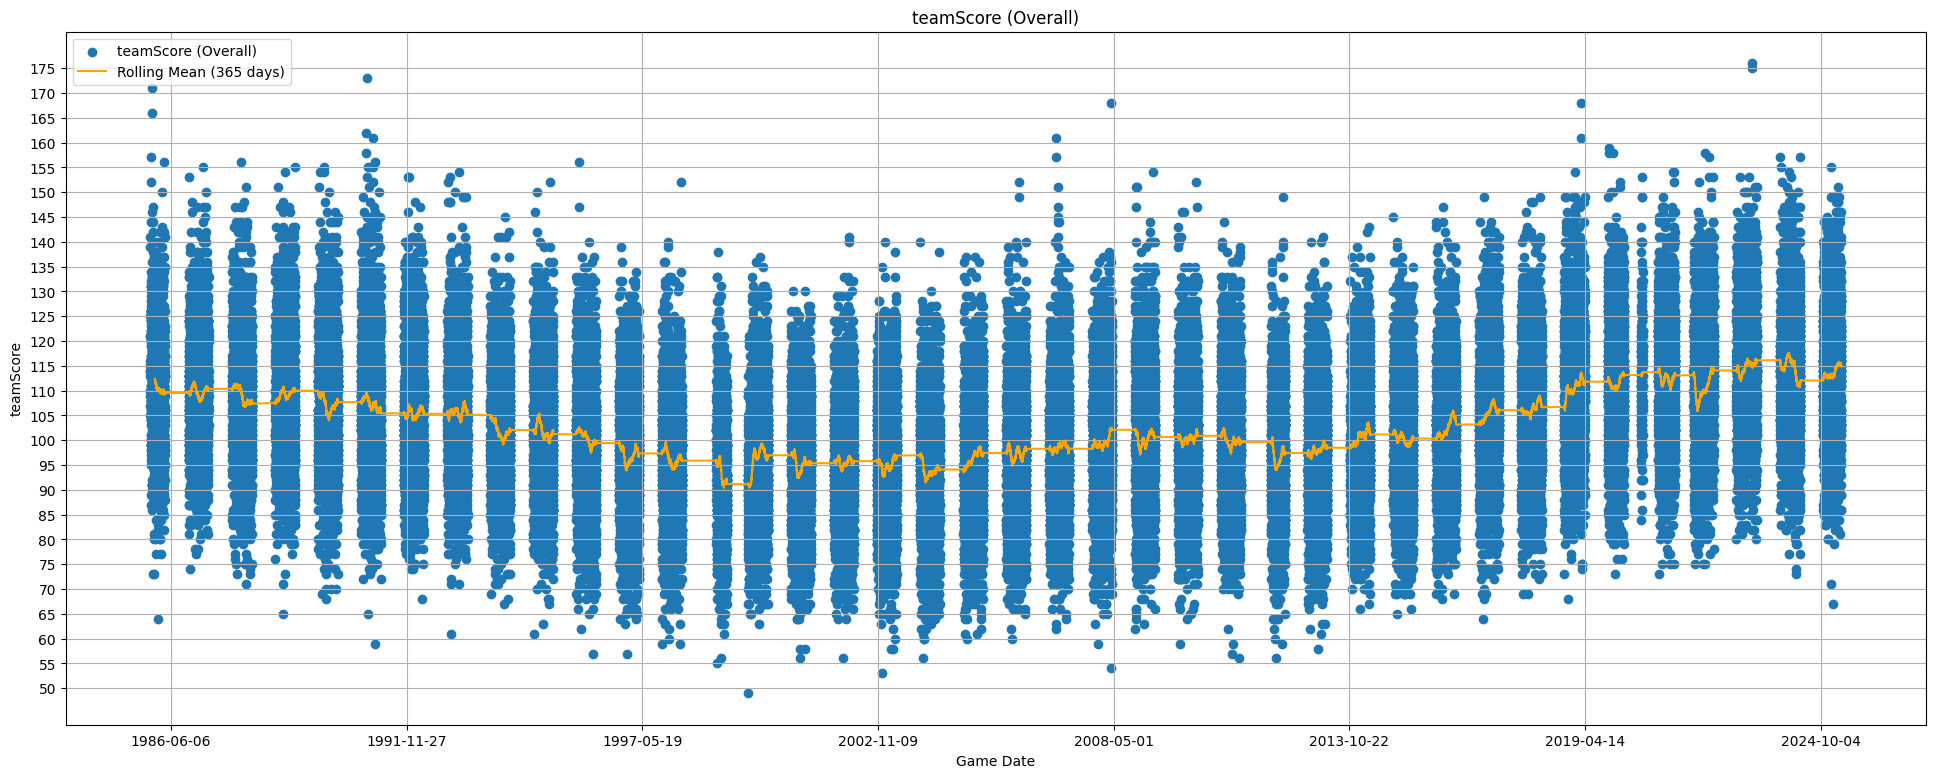

In [324]:
# plot
plot_time_series_separated(team_stat_df, "teamScore", fig_rowsize=9, yticks=np.arange(50, 180, 5), rolling_mean_window_size=365)

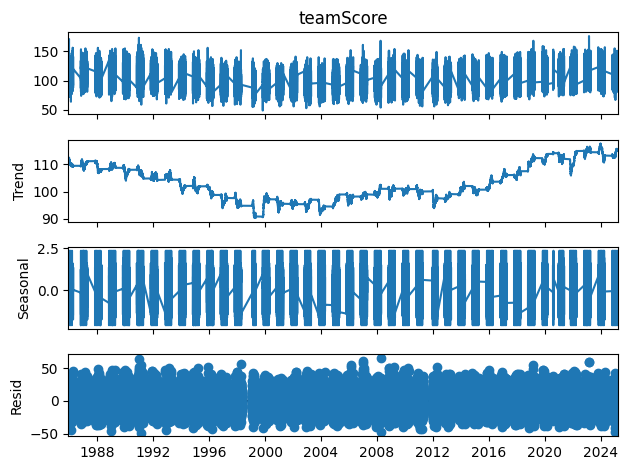

In [325]:
# seasonal decompose
decomposition = seasonal_decompose(team_stat_df["teamScore"], model='additive', period=365)

# plot
decomposition.plot()
plt.show()

## Seasonal Decompose with uniform time stamps


Converting the dataset to a uniform integer index because we want to ignore the actual time gaps and focus purely on the sequence of games. We are interested in patterns within the games themselves (e.g., trends in scores across games in a season) rather than the actual calendar time. And the time gaps (off-season) are not relevant to your analysis.


In [326]:
# uniform index df
team_stat_ui_df = team_stat_df.copy()
team_stat_ui_df.sort_values("gameDate", inplace=True, ascending=False)

# reset the index to a uniform integer index
team_stat_ui_df.reset_index(drop=True, inplace=True)

# new column for the uniform integer index (optional, for clarity)
team_stat_ui_df["gameDate"] = team_stat_df.index

In [327]:
team_stat_ui_df.head()

gameId   teamCity teamName opponentTeamCity opponentTeamName  home  win  \
0  22401058     Boston  Celtics          Phoenix             Suns     0    1   
1  22401058    Phoenix     Suns           Boston          Celtics     1    0   
2  22401057     Denver  Nuggets        Milwaukee            Bucks     1    1   
3  22401057  Milwaukee    Bucks           Denver          Nuggets     0    0   
4  22401056   New York   Knicks      Los Angeles         Clippers     1    0   

   teamScore  opponentScore  threePointersPercentage  ...  \
0        132            102                    0.423  ...   
1        102            132                    0.317  ...   
2        127            117                    0.432  ...   
3        117            127                    0.432  ...   
4        113            126                    0.382  ...   

   stealsPerPossession  threePointersAttemptedPerPossession  \
0             0.081900                             0.532351   
1             0.071254                             0.417345   
2             0.059595                             0.367501   
3             0.040933                             0.378633   
4             0.041806                             0.355351   

   freeThrowsAttemptedPerPossession  reboundsDefensivePerPossession  \
0                          0.225225                        0.378788   
1                          0.213762                        0.274837   
2                          0.218514                        0.377433   
3                          0.133033                        0.317233   
4                          0.229933                        0.323997   

   reboundsOffensivePerPossession  foulsPersonalPerPossession  \
0                        0.112613                    0.184275   
1                        0.111971                    0.183225   
2                        0.079460                    0.119190   
3                        0.081867                    0.143266   
4                        0.073161                    0.146321   

   turnoversPerPossession  effectiveFieldGoalPercentage  \
0                0.102375                     45.292135   
1                0.132329                     36.235632   
2                0.089392                     49.205556   
3                0.112567                     46.207865   
4                0.094064                     42.202381   

   trueShootingPercentage            gameDate  
0                0.668829 1985-12-11 20:00:00  
1                0.529925 1985-12-11 20:00:00  
2                0.637039 1985-12-11 20:00:00  
3                0.617610 1985-12-11 20:00:00  
4                0.603117 1985-12-11 20:00:00  

[5 rows x 23 columns]

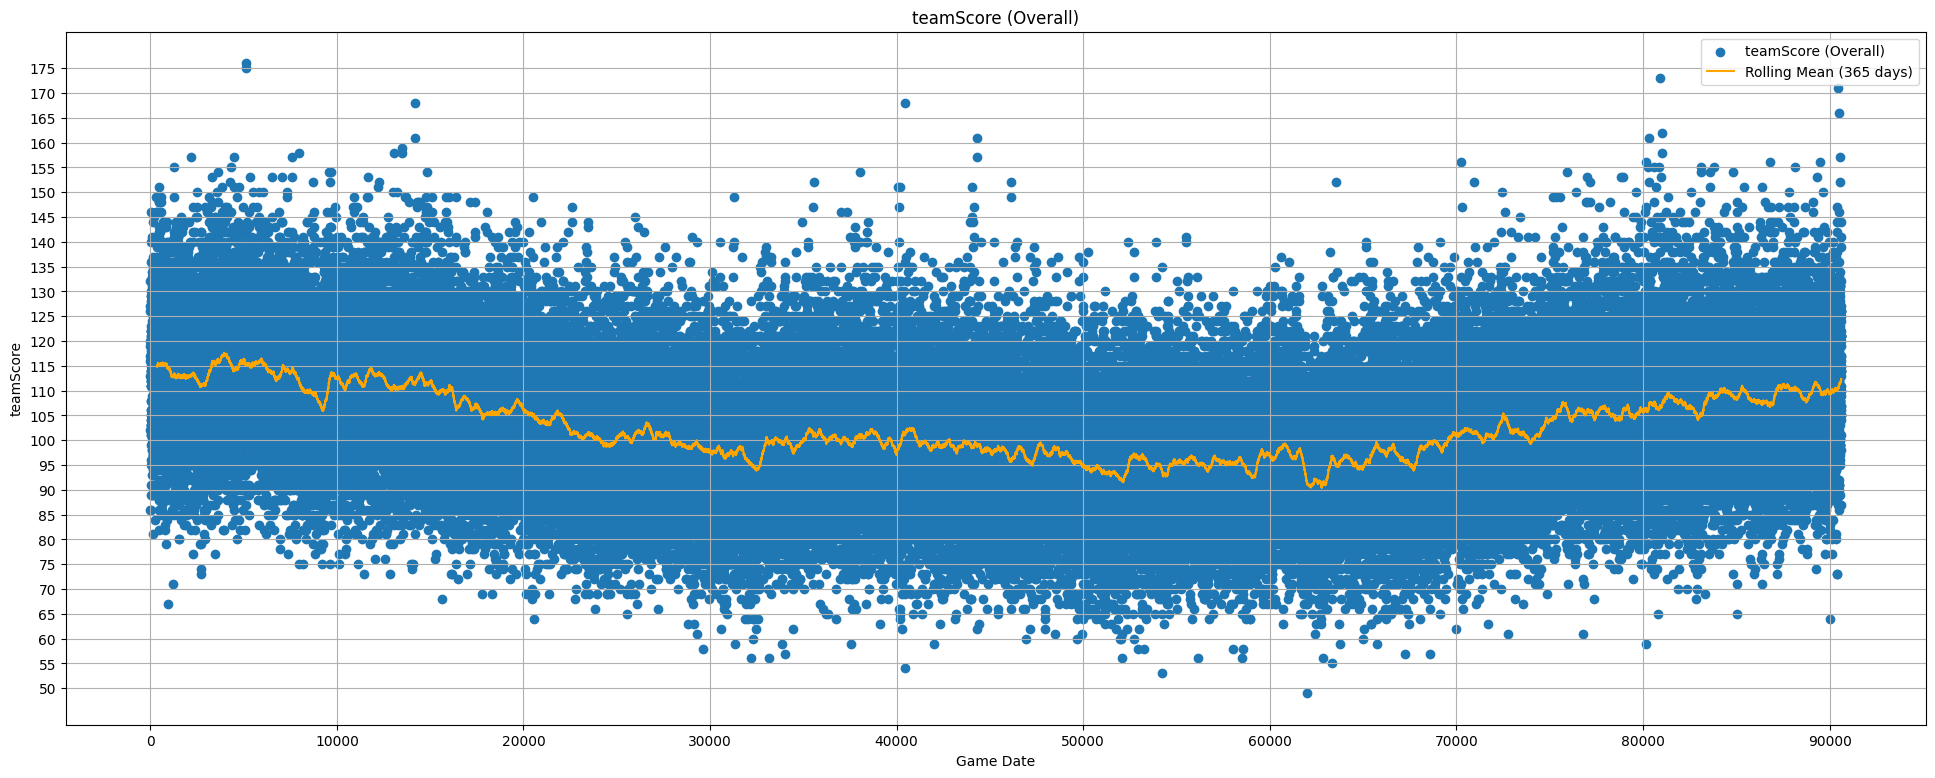

In [328]:
# plot it again
plot_time_series_separated(team_stat_ui_df, "teamScore", fig_rowsize=9, yticks=np.arange(50, 180, 5), rolling_mean_window_size=365)

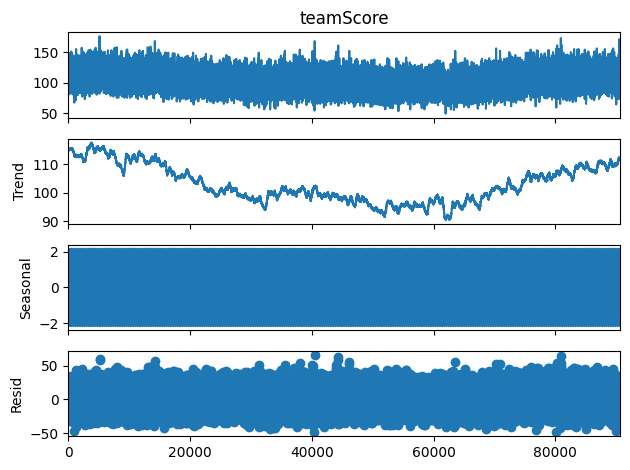

In [329]:
# seasonal decompose
decomposition_ui = seasonal_decompose(team_stat_ui_df["teamScore"], model='additive', period=365)

# plot
decomposition_ui.plot()
plt.show()

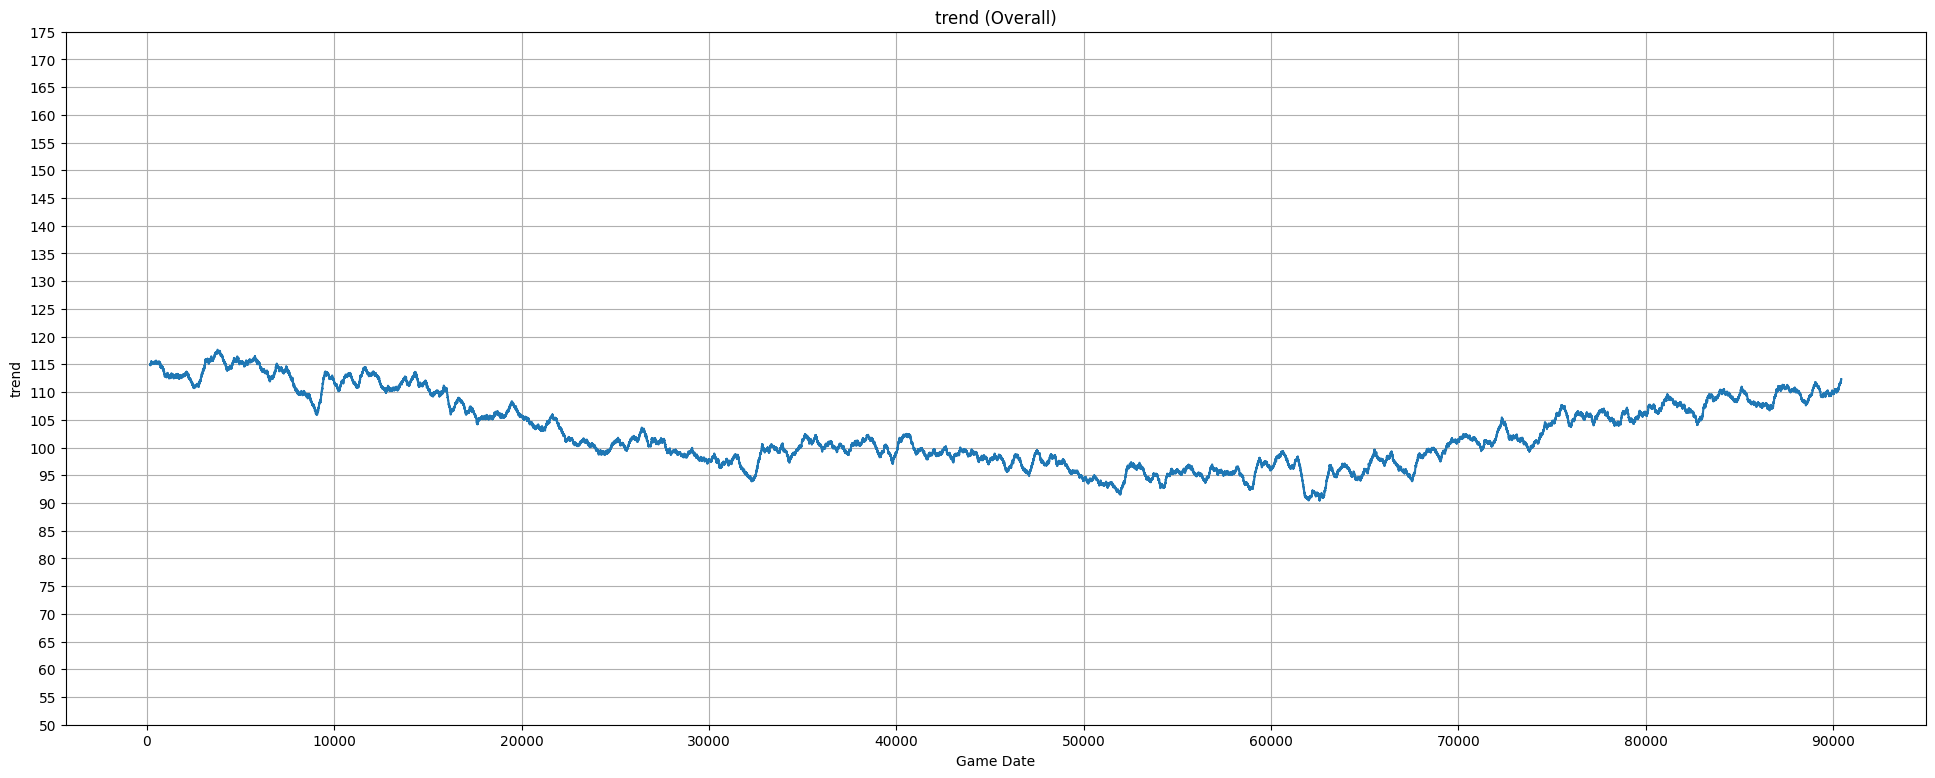

In [330]:
# plot trends
trend_ui = decomposition_ui.trend

# to df
trend_ui = pd.DataFrame(trend_ui)
trend_ui.columns = ["trend"]

plot_time_series_separated(trend_ui, "trend", fig_rowsize=9, yticks=np.arange(50, 180, 5), scatter=False, rolling_mean_window_size=None)

# Major rule changes analysis

 Key Rule Changes:
- 1954: Shot Clock Introduced
- 1964: Lane expanded
- 1979: Hand-Checking Banned
- 1980: Three-Point Line introduced
- 1995: Three-Point Line moved closer and stricter hand-checking rules
- 2002: Zone Defense Legalized
- 2005: Hand Checking Banned Permanently

## Data Prep

In [331]:
# split df into those periods: [-inf, 1994], [1995, 2001], [2002,2004], [2005, today]
separation_dates = ["1995-01-01", "2002-01-01", "2005-01-01"]
team_stat_df_three_point_line_introduced = team_stat_ui_df[team_stat_ui_df["gameDate"] < separation_dates[0]]
team_stat_df_three_point_line_moved = team_stat_ui_df[(team_stat_ui_df["gameDate"] >= separation_dates[0]) & (team_stat_ui_df["gameDate"] < separation_dates[1])]
team_stat_df_zone_defense_legalized = team_stat_ui_df[(team_stat_ui_df["gameDate"] >= separation_dates[1]) & (team_stat_ui_df["gameDate"] < separation_dates[2])]
team_stat_df_hand_checking_banned = team_stat_ui_df[team_stat_ui_df["gameDate"] >= separation_dates[2]]

In [332]:
# sort by index
team_stat_df_three_point_line_introduced.sort_index(inplace=True, ascending=True)
team_stat_df_three_point_line_introduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18570 entries, 0 to 18569
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   gameId                               18570 non-null  int64         
 1   teamCity                             18570 non-null  object        
 2   teamName                             18570 non-null  object        
 3   opponentTeamCity                     18570 non-null  object        
 4   opponentTeamName                     18570 non-null  object        
 5   home                                 18570 non-null  int64         
 6   win                                  18570 non-null  int64         
 7   teamScore                            18570 non-null  int64         
 8   opponentScore                        18570 non-null  int64         
 9   threePointersPercentage              18570 non-null  float64       
 10  freeThrowsPerce

In [333]:
# get the index that's closest to the dates
separation_indexes = []
for d in separation_dates:
     target_date = pd.to_datetime(d)
     date_differences = abs(team_stat_ui_df["gameDate"] - target_date)
     closest_date_index = date_differences.idxmin()
     separation_indexes.append((int(closest_date_index), d))
separation_indexes

[(18544, '1995-01-01'), (34249, '2002-01-01'), (41371, '2005-01-01')]

In [334]:
team_stat_ui_df

gameId       teamCity   teamName opponentTeamCity opponentTeamName  \
0      22401058         Boston    Celtics          Phoenix             Suns   
1      22401058        Phoenix       Suns           Boston          Celtics   
2      22401057         Denver    Nuggets        Milwaukee            Bucks   
3      22401057      Milwaukee      Bucks           Denver          Nuggets   
4      22401056       New York     Knicks      Los Angeles         Clippers   
...         ...            ...        ...              ...              ...   
90621  22300002      Milwaukee      Bucks         New York           Knicks   
90622  22300002       New York     Knicks        Milwaukee            Bucks   
90623  22300001      Cleveland  Cavaliers          Indiana           Pacers   
90624  22300005  Oklahoma City    Thunder     Golden State         Warriors   
90625  22300001        Indiana     Pacers        Cleveland        Cavaliers   

       home  win  teamScore  opponentScore  threePointersPercentage  ...  \
0         0    1        132            102                    0.423  ...   
1         1    0        102            132                    0.317  ...   
2         1    1        127            117                    0.432  ...   
3         0    0        117            127                    0.432  ...   
4         1    0        113            126                    0.382  ...   
...     ...  ...        ...            ...                      ...  ...   
90621     1    1        110            105                    0.513  ...   
90622     0    0        105            110                    0.256  ...   
90623     0    0        116            121                    0.286  ...   
90624     1    0        139            141                    0.517  ...   
90625     1    1        121            116                    0.484  ...   

       stealsPerPossession  threePointersAttemptedPerPossession  \
0                 0.081900                             0.532351   
1                 0.071254                             0.417345   
2                 0.059595                             0.367501   
3                 0.040933                             0.378633   
4                 0.041806                             0.355351   
...                    ...                                  ...   
90621             0.059218                             0.384919   
90622             0.058824                             0.382353   
90623             0.097087                             0.271845   
90624             0.027726                             0.268022   
90625             0.064480                             0.285556   

       freeThrowsAttemptedPerPossession  reboundsDefensivePerPossession  \
0                              0.225225                        0.378788   
1                              0.213762                        0.274837   
2                              0.218514                        0.377433   
3                              0.133033                        0.317233   
4                              0.229933                        0.323997   
...                                 ...                             ...   
90621                          0.276352                        0.335570   
90622                          0.245098                        0.392157   
90623                          0.242718                        0.291262   
90624                          0.277264                        0.231054   
90625                          0.221076                        0.303979   

       reboundsOffensivePerPossession  foulsPersonalPerPossession  \
0                            0.112613                    0.184275   
1                            0.111971                    0.183225   
2                            0.079460                    0.119190   
3                            0.081867                    0.143266   
4                            0.073161                    0.146321   
...                        

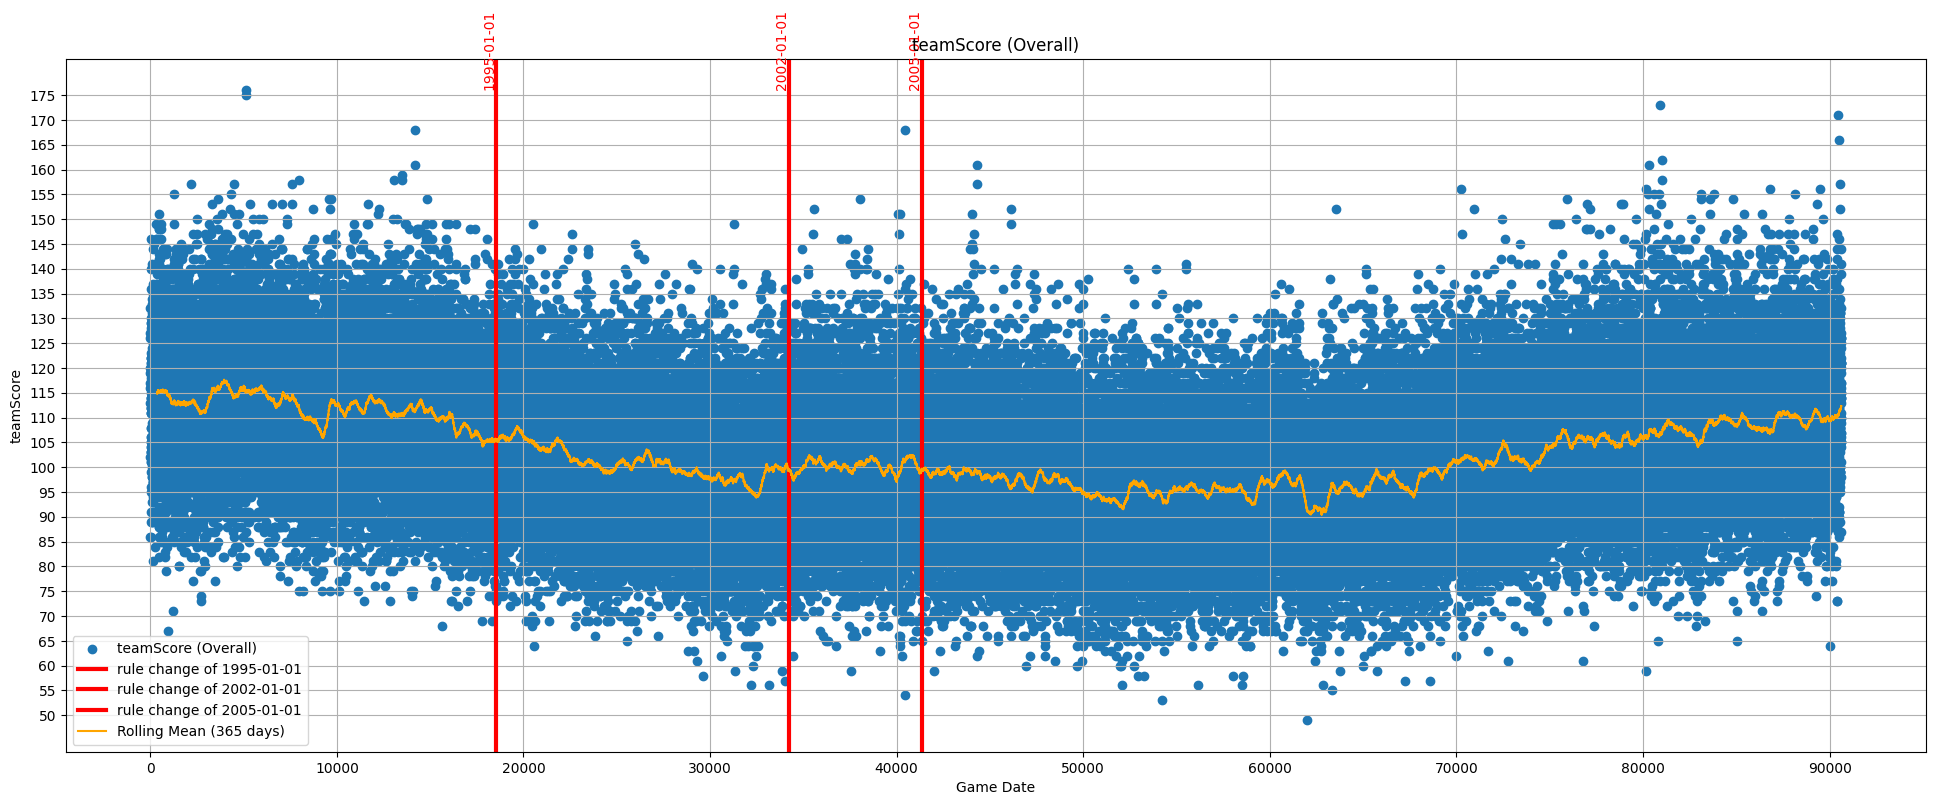

In [349]:
dataframes_to_plot = [team_stat_df_three_point_line_introduced,
                      team_stat_df_three_point_line_moved,
                      team_stat_df_zone_defense_legalized,
                      team_stat_df_hand_checking_banned]

plot_time_series_separated(team_stat_ui_df, 'teamScore',  separation_dates=separation_indexes, rolling_mean_window_size=365, fig_rowsize=9, yticks=np.arange(50, 180, 5), sep_line_width=3)

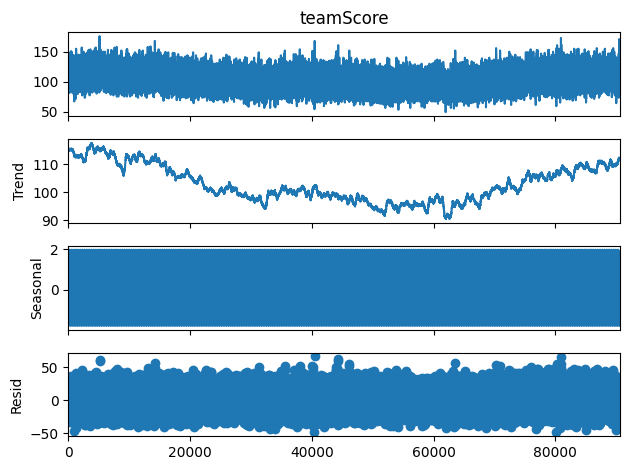

In [303]:
decomposition = seasonal_decompose(team_stat_ui_df["teamScore"], model='additive', period=365)
decomposition.plot()
plt.show()

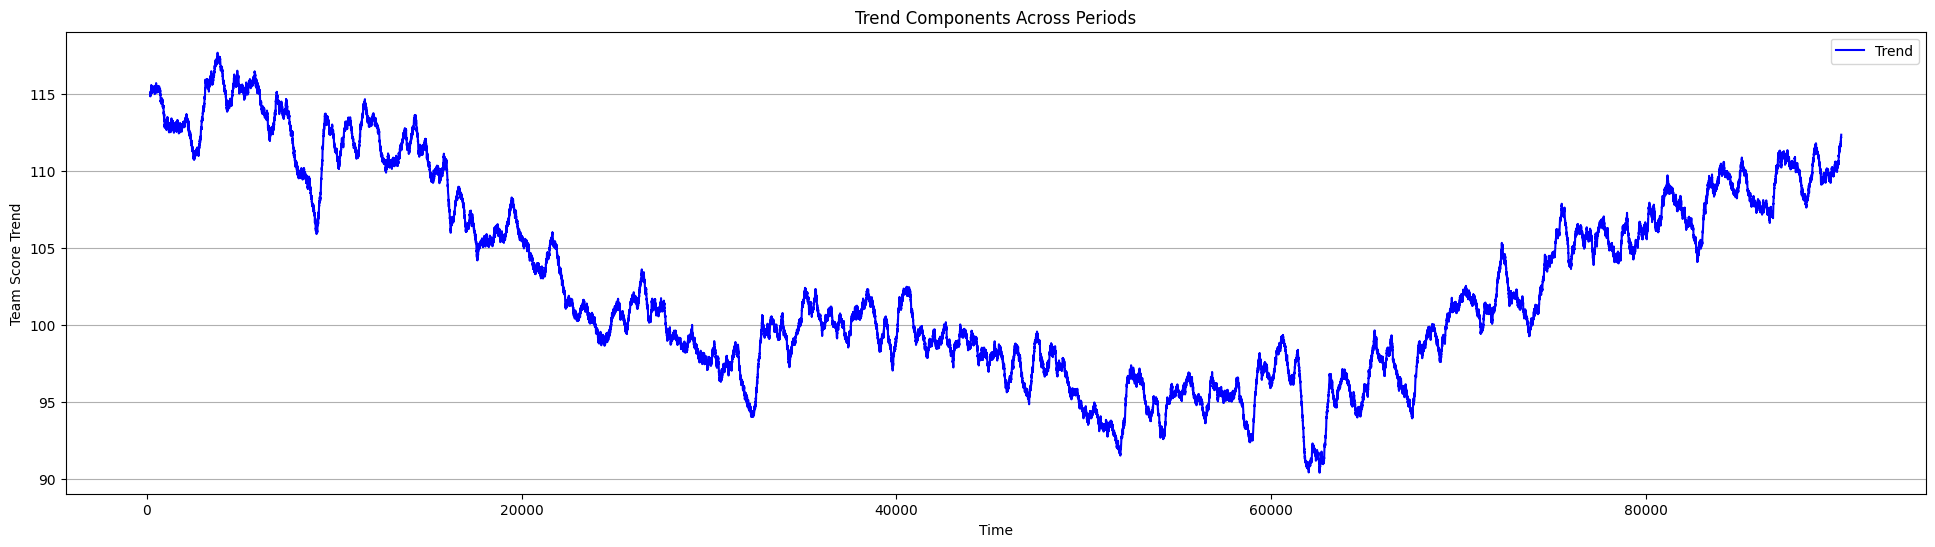

In [304]:
# plot the trends nicely
trend_overall = decomposition.trend

# to df
trend_overall = pd.DataFrame(trend_overall)
trend_overall.columns = ["trend"]


# Plot the trends
plt.figure(figsize=(24, 6))
plt.plot(trend_overall, label='Trend', color='blue')
plt.grid(axis = 'y')

# Add labels and legend
plt.title('Trend Components Across Periods')
plt.xlabel('Time')
plt.ylabel('Team Score Trend')
plt.legend()
plt.show()

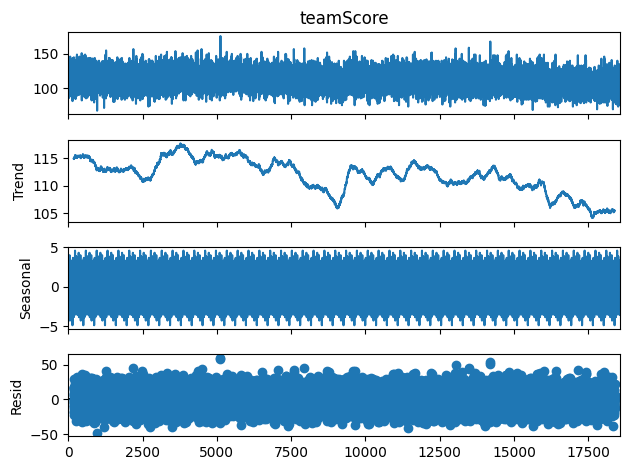

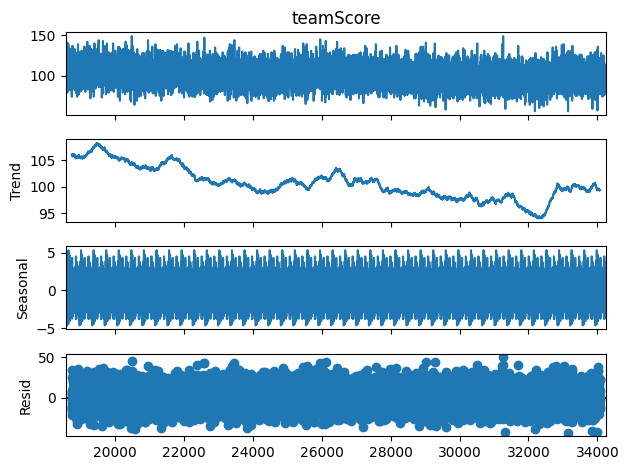

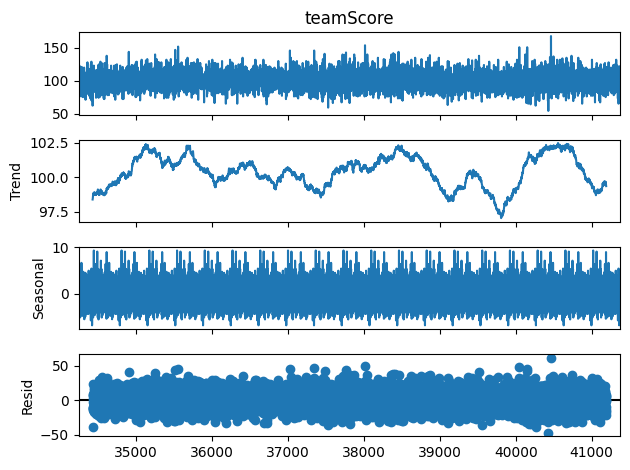

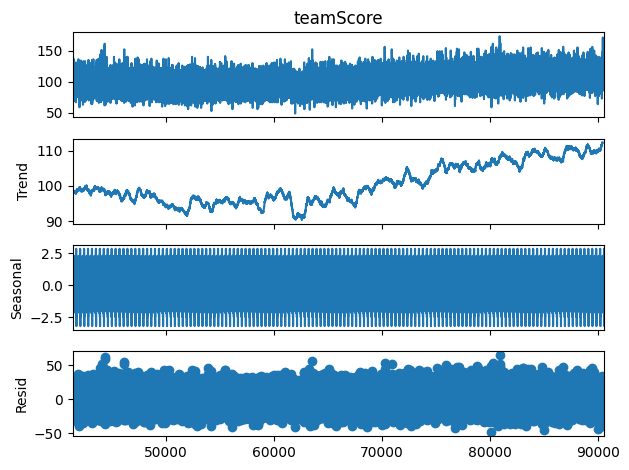

In [305]:
## seasonal decompose on each period
decomposition_three_point_line_introduced = seasonal_decompose(team_stat_df_three_point_line_introduced["teamScore"], model='additive', period=365)
decomposition_three_point_line_introduced.plot()
plt.show()

decomposition_three_point_line_moved = seasonal_decompose(team_stat_df_three_point_line_moved["teamScore"], model='additive', period=365)
decomposition_three_point_line_moved.plot()
plt.show()

decomposition_zone_defense_legalized = seasonal_decompose(team_stat_df_zone_defense_legalized["teamScore"], model='additive', period=365)
decomposition_zone_defense_legalized.plot()
plt.show()

decomposition_hand_checking_banned = seasonal_decompose(team_stat_df_hand_checking_banned["teamScore"], model='additive', period=365)
decomposition_hand_checking_banned.plot()
plt.show()

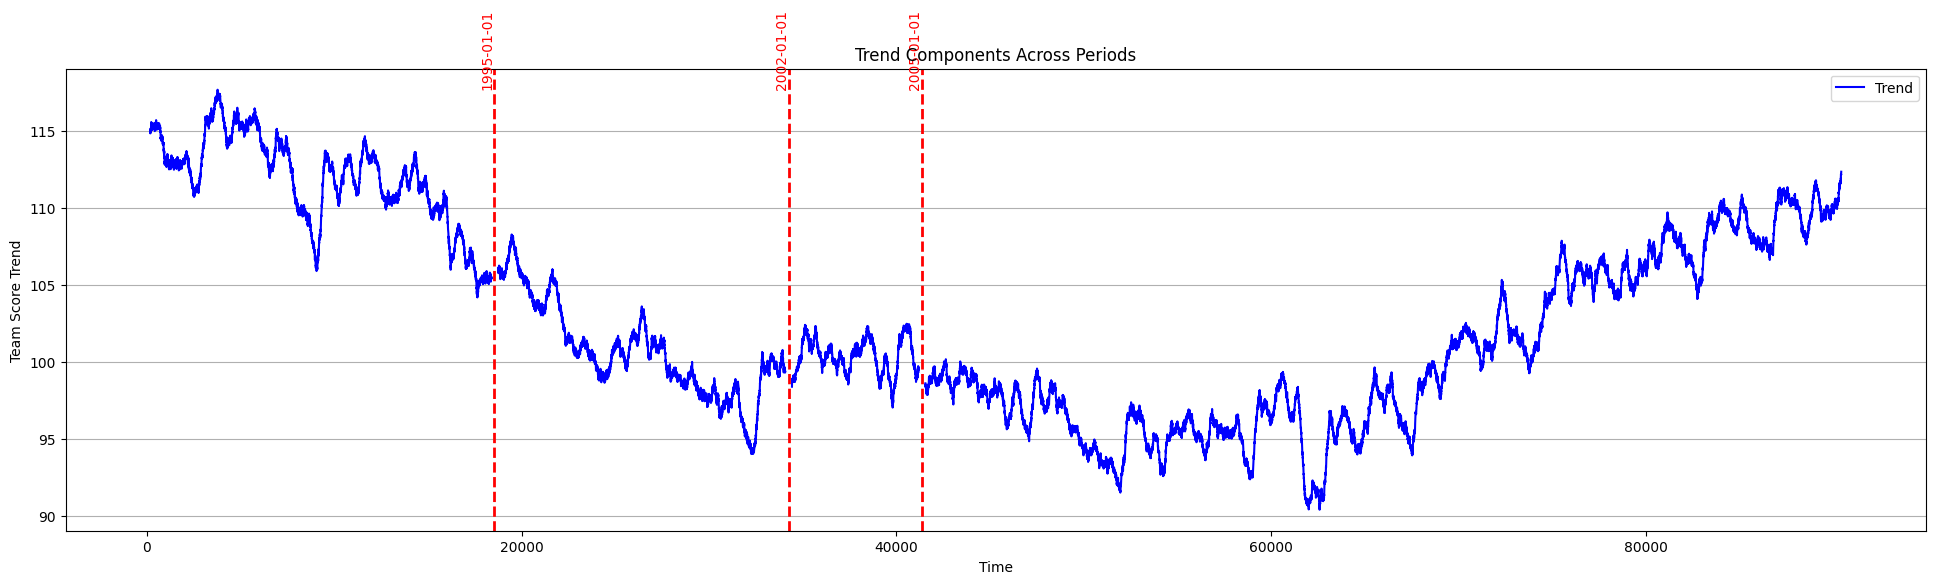

In [353]:
# Extract trends
trends = [
    decomposition_hand_checking_banned.trend,
    decomposition_zone_defense_legalized.trend,
    decomposition_three_point_line_moved.trend,
    decomposition_three_point_line_introduced.trend,
]

# Combine trends into a single series
trend_combined = pd.concat(trends)

# Plot the trends
plt.figure(figsize=(24, 6))
plt.plot(trend_combined, label='Trend', color='blue')
plt.grid(axis = 'y')

# Add vertical separation lines
for index, date in separation_indexes:
    plt.axvline(x=index, color='red', linestyle='--', linewidth=2)
    plt.text(index, trend_combined.max(), date, ha='right', va='bottom', color='red', rotation=90)

# Add labels and legend
plt.title('Trend Components Across Periods')
plt.xlabel('Time')
plt.ylabel('Team Score Trend')
plt.legend()
plt.show()

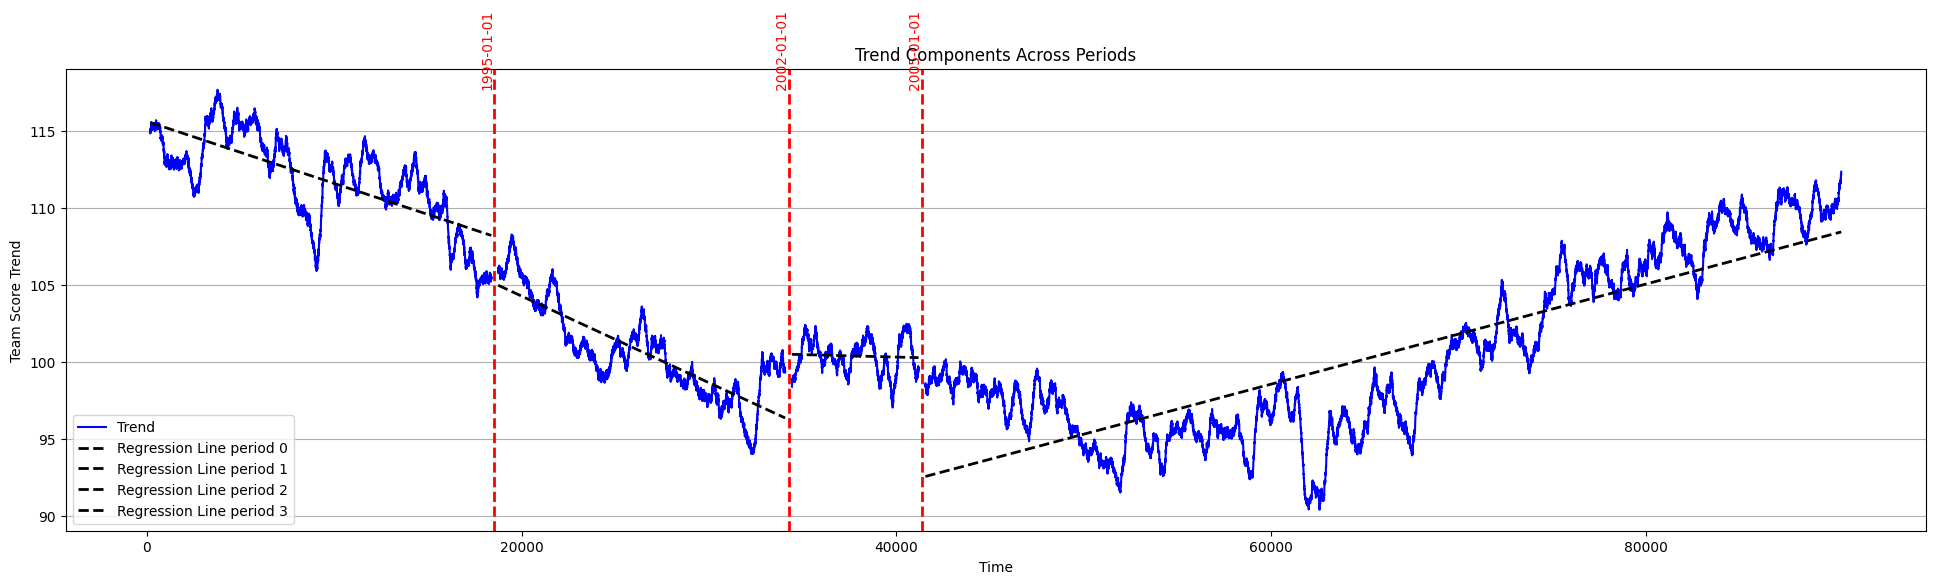

In [354]:
# Plot the trends
plt.figure(figsize=(24, 6))
plt.plot(trend_combined, label='Trend', color='blue')
plt.grid(axis = 'y')

# Add vertical separation lines
for index, date in separation_indexes:
    plt.axvline(x=index, color='red', linestyle='--', linewidth=2)
    plt.text(index, trend_combined.max(), date, ha='right', va='bottom', color='red', rotation=90)

# calculate linear regresssions
for i, trend in enumerate(trends):
    trend = trend.dropna()
    x = np.arange(len(trend))
    y = trend.values
    slope, intercept, _, _, _ = linregress(x, y)
    regression_line = slope * x + intercept
    plt.plot(trend.index, regression_line, linestyle='--', label=f'Regression Line period {i}', color='black', linewidth=2)

# Add labels and legend
plt.title('Trend Components Across Periods')
plt.xlabel('Time')
plt.ylabel('Team Score Trend')
plt.legend()
plt.show()